## Setup Google Colab

First, mount Google Drive to access files:

In [15]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# project_name = "SeamTaping"
project_name = "WRB"
print("Project:", project_name)

# Path to saved images
image_folder = f'/content/gdrive/MyDrive/CrackDetection/{project_name}_images'

# Load dataset from JSON
dataset_json_path = f'/content/gdrive/MyDrive/CrackDetection/{project_name}_All_bbox_annotations.json'


Mounted at /content/gdrive
Project: WRB


## Define Custom Dataset Class

Create a custom dataset class to load images and annotations.

In [16]:
import os
import json
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image, ImageDraw

class CustomDataset(Dataset):
    def __init__(self, dataset_json_path, image_folder):
        with open(dataset_json_path, 'r') as f:
            dataset = json.load(f)

        self.dataset = dataset
        self.image_folder = image_folder
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.image_size = (800, 800)
        self.transforms = T.Compose([
            T.Resize(self.image_size),
            T.ToTensor(),
            T.Normalize(mean=self.mean, std=self.std)
        ])

        self.label_map = {
            'WRB-Bad': 0,
            # Add more labels as needed
        }

    def __len__(self):
        return len(self.dataset)

    def xywh_to_xyxy(self, xywh):
        x, y, w, h = xywh
        x2 = x + w
        y2 = y + h
        xyxy = [x, y, x2, y2]
        return xyxy

    def __getitem__(self, idx):
        image_data = self.dataset[idx]
        image_file_name = image_data['image_file_name']
        image_path = os.path.join(self.image_folder, image_file_name)

        # Load image
        image_original = Image.open(image_path).convert("RGB")

        # Get bounding boxes and labels
        boxes = []
        labels = []
        for annotation in image_data['annotations']:
            bbox = annotation['bbox']
            box = self.xywh_to_xyxy(bbox)
            boxes.append(box)
            labels.append(self.label_map[annotation['label']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Apply transformations
        if self.transforms is not None:
            image = self.transforms(image_original)

        # Calculate scaling factor for resizing bounding boxes AFTER transforms
        original_size = np.array(image_original.size)  # Get original size from the image file
        # print(original_size)
        resized_size = self.image_size
        scale = resized_size / original_size
        # print(scale)

        # Adjust bounding box coordinates based on resizing
        boxes[:, 0] *= scale[0]  # x_min
        boxes[:, 1] *= scale[1]  # y_min
        boxes[:, 2] *= scale[0]  # x_max
        boxes[:, 3] *= scale[1]  # y_max

        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return image, target

# Create custom dataset instance with augmentation enabled
custom_dataset = CustomDataset(dataset_json_path, image_folder)

## Check CustomDataset Class


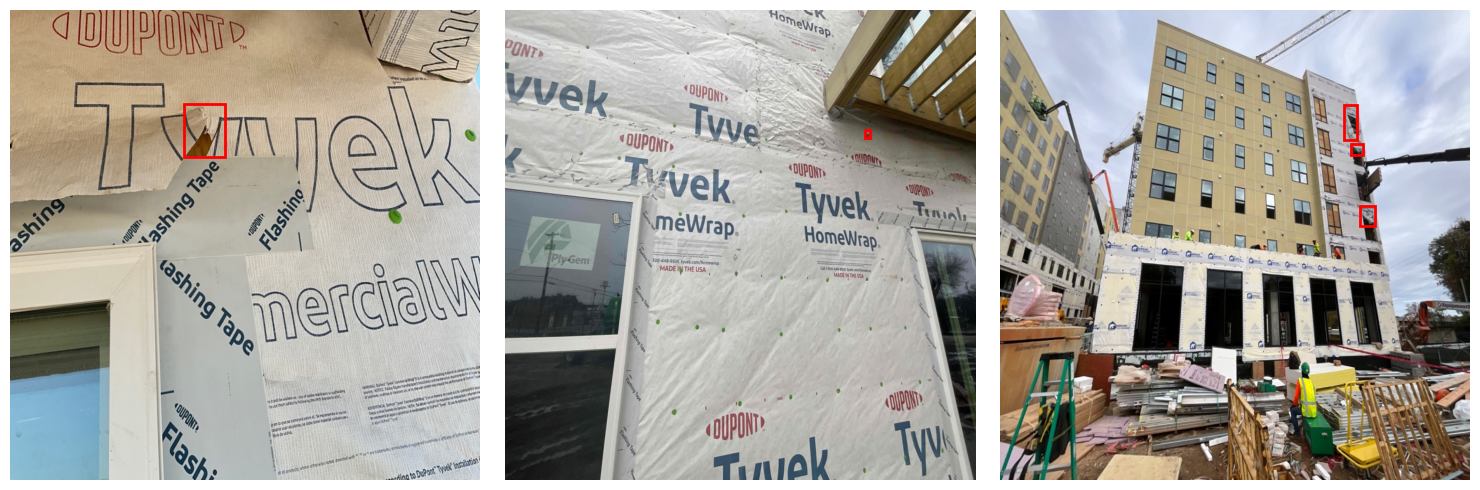

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Function to display images with bounding boxes
def display_images_bboxes(images, boxes_list, labels_list, mean=None, std=None):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Adjust figsize as needed

    for i in range(num_images):
        # Select the i-th image and convert to NumPy array
        image = images[i].cpu().numpy()  # Convert PyTorch tensor to NumPy array
        image = np.transpose(image, (1, 2, 0))  # Convert from channels first to channels last (if needed)

        # Reverse normalization if mean and std are provided
        if mean is not None and std is not None:
            mean = np.array(mean)
            std = np.array(std)
            image = (image * std + mean) * 255
            image = image.astype(np.uint8)

        ax = axes[i]
        ax.imshow(image)

        # Draw bounding boxes
        boxes = boxes_list[i]
        labels = labels_list[i]
        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            # ax.text(xmin, ymin, f'Label {label}', fontsize=12, color='red')

        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
# Assume custom_dataset is defined somewhere and contains images and targets

# Randomly select 3 indices
indices = random.sample(range(len(custom_dataset)), 3)

# Prepare data for display
images = []
boxes_list = []
labels_list = []

for idx in indices:
    image, target = custom_dataset[idx]
    images.append(image)
    boxes_list.append(target["boxes"])
    labels_list.append(target["labels"])

# Display images with bounding boxes
display_images_bboxes(images,
                      boxes_list,
                      labels_list,
                      mean=custom_dataset.mean,
                      std=custom_dataset.std)
